In [2]:
pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Hibatullah\.cache\kagglehub\datasets\jehanbhathena\weather-dataset\versions\3


In [25]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

In [10]:
# Dataset path
data_dir = r"C:\Users\Hibatullah\CA\DL\Project\weather"


# Parameters
batch_size = 32
img_height = 180
img_width = 180
seed = 123


In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3116 files belonging to 8 classes.
Using 2493 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3116 files belonging to 8 classes.
Using 623 files for validation.
Classes: ['cloudy', 'foggy', 'lightning', 'rainbow', 'rainy', 'rime', 'sandstorm', 'sunrise']


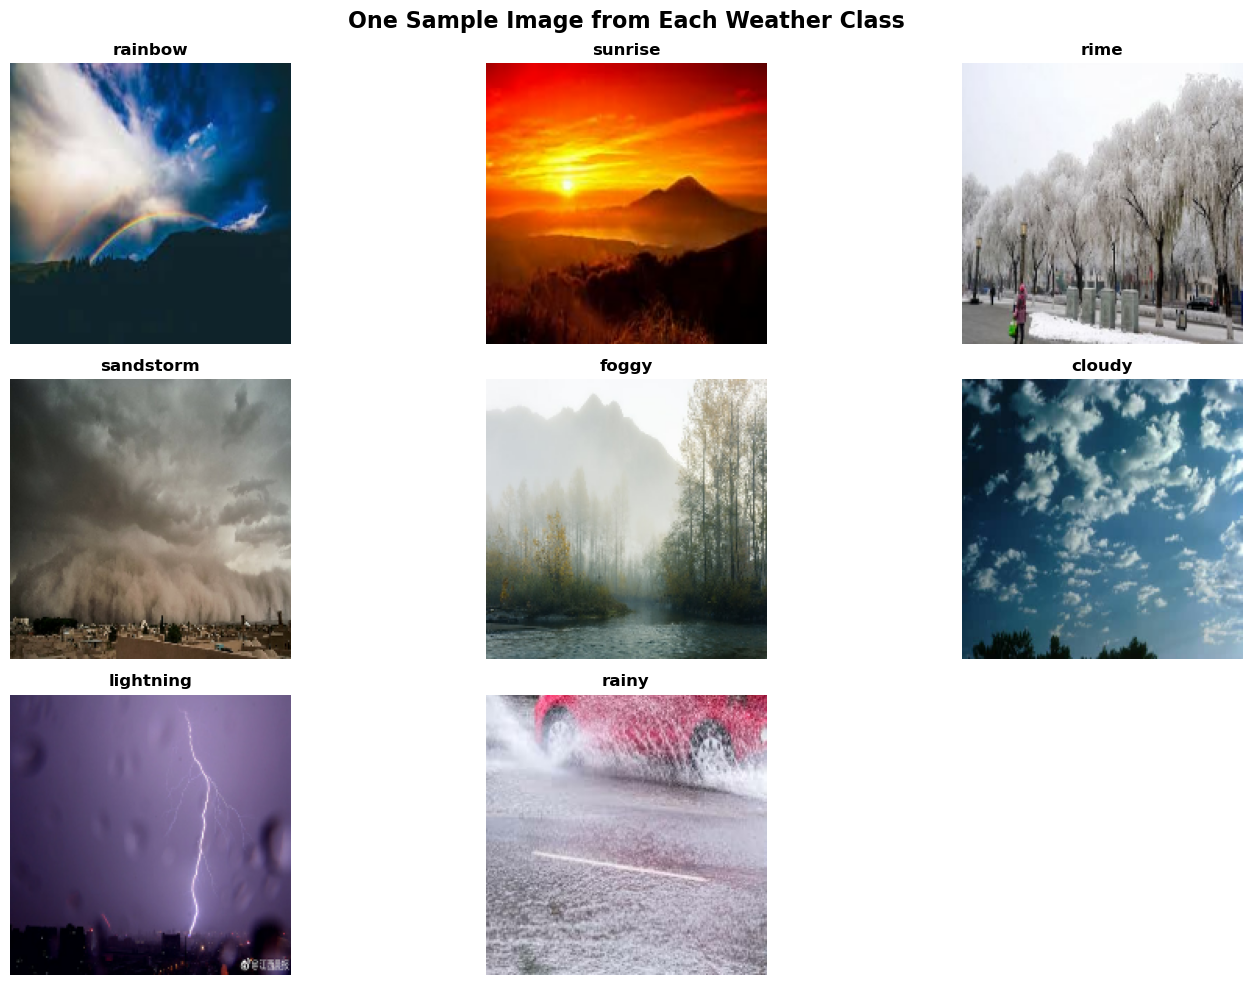

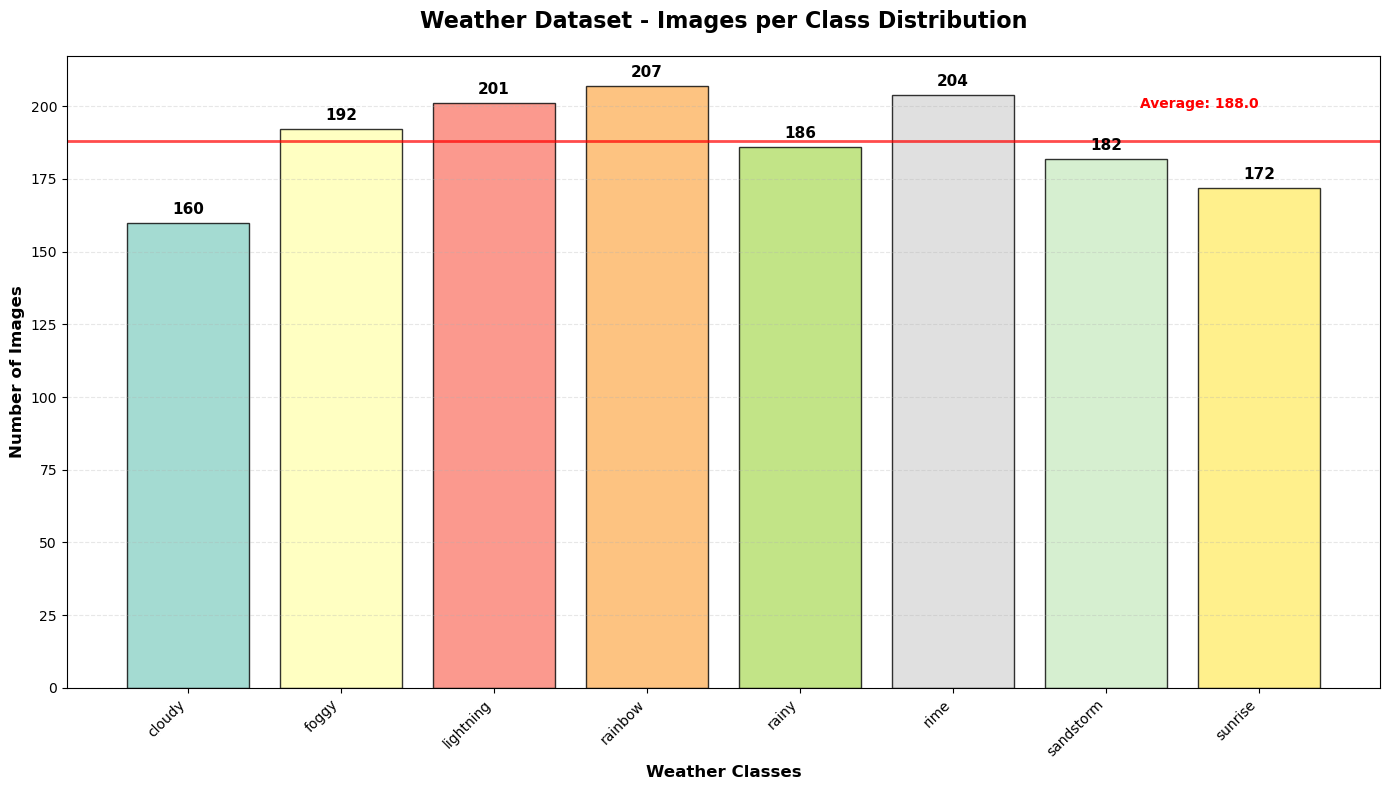


Summary:
Total classes: 8
Total images: 1504
Average per class: 188.0
Most common: rainbow (207 images)
Least common: cloudy (160 images)
✅ Dataset is well balanced


In [ ]:
displayed_classes = set()
images_to_show = []

try:
    for images, labels in train_ds:
        try:
            for i in range(len(images)):
                class_idx = labels[i].numpy()
                
                if class_idx not in displayed_classes:
                    images_to_show.append((images[i], class_idx))
                    displayed_classes.add(class_idx)
                
                if len(images_to_show) >= len(class_names):
                    break
            if len(images_to_show) >= len(class_names):
                break
        except Exception as e:
            continue
except Exception as e:
    pass

plt.figure(figsize=(15, 10))
for i, (image, label_idx) in enumerate(images_to_show):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"{class_names[label_idx]}", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.suptitle('One Sample Image from Each Weather Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


class_indices = sorted(class_counts.keys())
counts = [class_counts[idx] for idx in class_indices]
names = [class_names[idx] for idx in class_indices]

plt.figure(figsize=(14, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(names)))  # Different colors for each bar
bars = plt.bar(names, counts, color=colors, edgecolor='black', alpha=0.8)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('Weather Dataset - Images per Class Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Weather Classes', fontweight='bold', fontsize=12)
plt.ylabel('Number of Images', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

avg_line = total_images / len(class_counts)
plt.axhline(y=avg_line, color='red', linestyle='-', alpha=0.7, linewidth=2)
plt.text(len(names)-1, avg_line + max(counts)*0.05, f'Average: {avg_line:.1f}', 
         ha='right', va='bottom', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSummary:")
print(f"Total classes: {len(class_counts)}")
print(f"Total images: {total_images}")
print(f"Average per class: {total_images/len(class_counts):.1f}")
print(f"Most common: {class_names[max(class_counts, key=class_counts.get)]} ({max(class_counts.values())} images)")
print(f"Least common: {class_names[min(class_counts, key=class_counts.get)]} ({min(class_counts.values())} images)")

if max(class_counts.values())/min(class_counts.values()) > 2:
    print("⚠️  Dataset appears imbalanced")
else:
    print("✅ Dataset is well balanced")